In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Gibbs Sampling

In [2]:
from gibbsrank import gibbs_sample
samps = 1100

In [3]:
with open("./tennis_data.npy", 'rb') as f:
    data = np.load(f, allow_pickle=True).item() # 0 dimensional array of object dtype
    W = data['W']
    G = data['G']-1
    f.close()

In [4]:
skillsg = gibbs_sample(G, W.shape[0], samps)

100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [02:59<00:00,  6.14it/s]


<IPython.core.display.Javascript object>


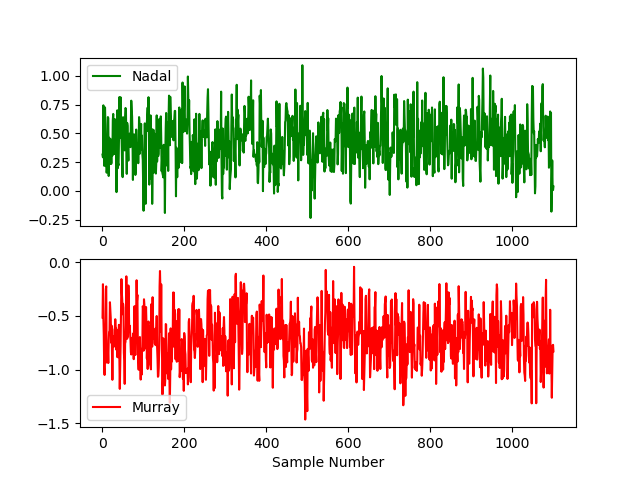

<IPython.core.display.Javascript object>


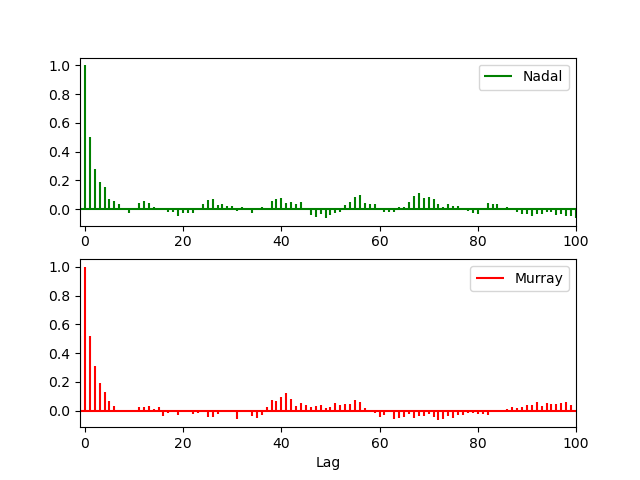

Text(0.5, 0, 'Lag')

In [5]:
skills = skillsg
fig1, [ax1, ax2] = plt.subplots(nrows=2)
fig2, [ax3, ax4] = plt.subplots(nrows=2)
ax1.plot(np.arange(1, samps+1), skills[20,:], color='green', label='Nadal')
ax2.plot(np.arange(1, samps+1), skills[51,:], color='red', label='Murray')
ax3.acorr(skills[0,:]-np.mean(skills[0,:]), maxlags=100, color='green', label='Nadal')
ax4.acorr(skills[10,:]-np.mean(skills[10,:]), maxlags=100, color='red', label='Murray')
ax3.set_xlim([-1, 100])
ax4.set_xlim([-1, 100])
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax1.set_title('Gibbs Samples')
# ax2.set_title('Autocorrelation')
ax2.set_xlabel('Sample Number')
ax4.set_xlabel('Lag')

<IPython.core.display.Javascript object>


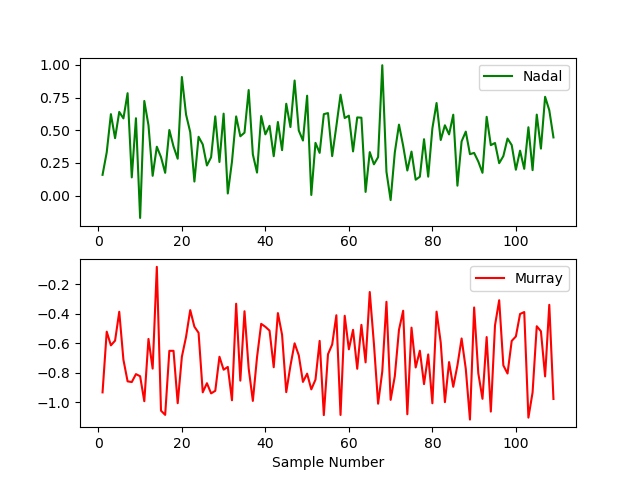

<IPython.core.display.Javascript object>


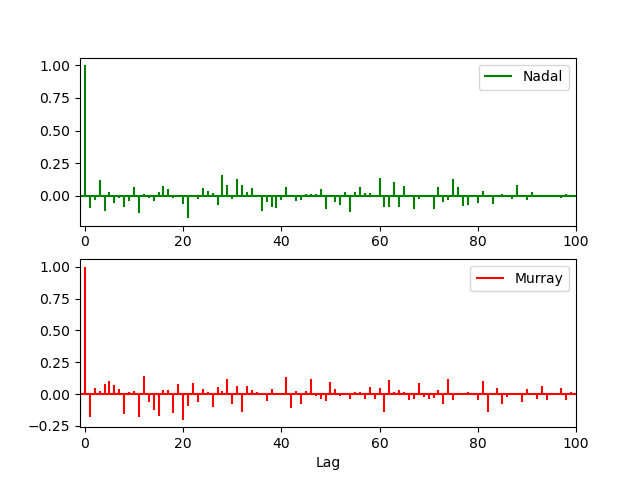

Text(0.5, 0, 'Lag')

In [6]:
skills = skillsg[:,10::10]
fig1, [ax1, ax2] = plt.subplots(nrows=2)
fig2, [ax3, ax4] = plt.subplots(nrows=2)
ax1.plot(np.arange(1, skills.shape[1]+1), skills[20,:], color='green', label='Nadal')
ax2.plot(np.arange(1, skills.shape[1]+1), skills[51,:], color='red', label='Murray')
ax3.acorr(skills[0,:]-np.mean(skills[0,:]), maxlags=100, color='green', label='Nadal')
ax4.acorr(skills[10,:]-np.mean(skills[10,:]), maxlags=100, color='red', label='Murray')
ax3.set_xlim([-1, 100])
ax4.set_xlim([-1, 100])
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax1.set_title('Gibbs Samples')
# ax2.set_title('Autocorrelation')
ax2.set_xlabel('Sample Number')
ax4.set_xlabel('Lag')

## Expectation Propagation

In [9]:
from eprank import eprank
from scipy.stats import norm
iters = 75

In [10]:
# m_values = np.zeros(iters)
# p_values = np.zeros(iters)
# for i in range(1, iters+1):
#     m_vec, p_vec = eprank(G, W.shape[0], i)
#     m_values[i-1] = m_vec[10]
#     p_values[i-1] = p_vec[10]

In [11]:
# fig, ax = plt.subplots()
# ax.set_title('Murray')
# ax1 = ax.twinx()
# ax.set_xlabel('Iteration')
# ax.plot(np.arange(1, iters+1), m_values, label='Mean')
# ax1.plot(np.arange(1, iters+1), 1./p_values, label='Variance', color='orange')
# ax1.set_ylabel('Variance')
# ax.set_ylabel('Mean')
# fig.legend()

In [12]:
Ms, Ps = eprank(G, W.shape[0], iters)

100%|█████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 242.24it/s]


In [13]:
djok = (Ms[15], 1./Ps[15])
nada = (Ms[0], 1./Ps[0])
fede = (Ms[4], 1./Ps[4])
murr = (Ms[10], 1./Ps[10])

In [14]:
def prob_skill_higher(p1, p2, correlation=0):
    return (1 - norm.cdf(0, (p1[0]-p2[0]), np.sqrt(p1[1]+p2[1]-2*correlation*np.sqrt(p1[1]*p2[1]))))

In [32]:
prob_skill_higher(djok, nada)

0.9398229674641677

In [35]:
def prob_winning(p1, p2, correlation=0):
    return (1 - norm.cdf(0, (p1[0]-p2[0]), np.sqrt(p1[1]+p2[1]+1-2*correlation*np.sqrt(p1[1]*p2[1]))))

In [36]:
prob_winning(djok, nada)

0.6553674774797235

In [37]:
prob_skill_higher((Ms[15], 1./Ps[15]),(Ms[104], 1./Ps[104]))

0.9999999943496201

## Inference for the Gibbs Samples

### Marginals

In [104]:
skills = skillsg[:,10::10]
djokg = (np.mean(skills[15,:]), np.var(skills[15,:]))
nadag = (np.mean(skills[0,:]), np.var(skills[0,:]))
fedeg = (np.mean(skills[4,:]), np.var(skills[4,:]))
murrg = (np.mean(skills[10,:]), np.var(skills[10,:]))

In [120]:
prob_skill_higher(djokg, nadag)

0.9207163590336744

In [111]:
prob_winning(djokg, fedeg)

0.6288521149362873

### Joint

In [97]:
djok_nada = np.vstack((skills[15,:], skills[0,:]))

In [98]:
joint_mean = np.mean(djok_nada, axis=1)

In [99]:
joint_covar = np.cov(djok_nada)

In [100]:
djokj = (joint_mean[0], joint_covar[0,0])
nadaj = (joint_mean[1], joint_covar[1,1])
rhodn = joint_covar[1,0]

In [101]:
joint_covar

array([[0.04762998, 0.00637937],
       [0.00637937, 0.03626063]])

In [102]:
prob_skill_higher(djokj, nadaj, correlation=rhodn)

0.9204167696363941

In [103]:
prob_winning(djokj, nadaj, correlation=rhodn)

0.6519292421133216

### Direct estimate

In [77]:
def direct_estimate(s1, s2):
    return np.array([1 if s1[i]>s2[i] else 0 for i in range(s1.shape[0])])

In [78]:
condition = direct_estimate(skills[15,:], skills[0,:])

In [79]:
np.count_nonzero(condition)/condition.shape[0]

0.9357798165137615

## Ranking

Players ranked by average winning probability

In [121]:
from cw2 import sorted_barplot

In [122]:
def average_win_prob_direct(player, g):
    games_played = 0
    games_won = 0
    for i in range(g.shape[0]):
        if g[i][0] == player:
            games_played += 1
            games_won += 1
        elif g[i][1] == player:
            games_played += 1
    return games_won/games_played

def average_win_prob_message(player, m, p):
    player_marginal = (m[player], 1./p[player])
    tot = 0
    for opponent in range(107):
        if opponent==player:
            pass
        else:
            opponent_marginal = (m[opponent], 1./p[opponent])
            tot += prob_winning(player_marginal, opponent_marginal)
            
    return tot/106.
            
    
def average_win_prob_gibbs(player, samples):
    player_marginal = (np.mean(skills[player,:]), np.var(skills[player,:]))
    tot = 0
    for opponent in range(107):
        if opponent==player:
            pass
        else:
            opponent_marginal = (np.mean(skills[opponent,:]), np.var(skills[opponent,:]))
            tot += prob_winning(player_marginal, opponent_marginal)
            
    return tot/106.

In [123]:
mpassing_probs = np.zeros(107)
for player in range(107):
    mpassing_probs[player] = average_win_prob_message(player, Ms, Ps)

<IPython.core.display.Javascript object>


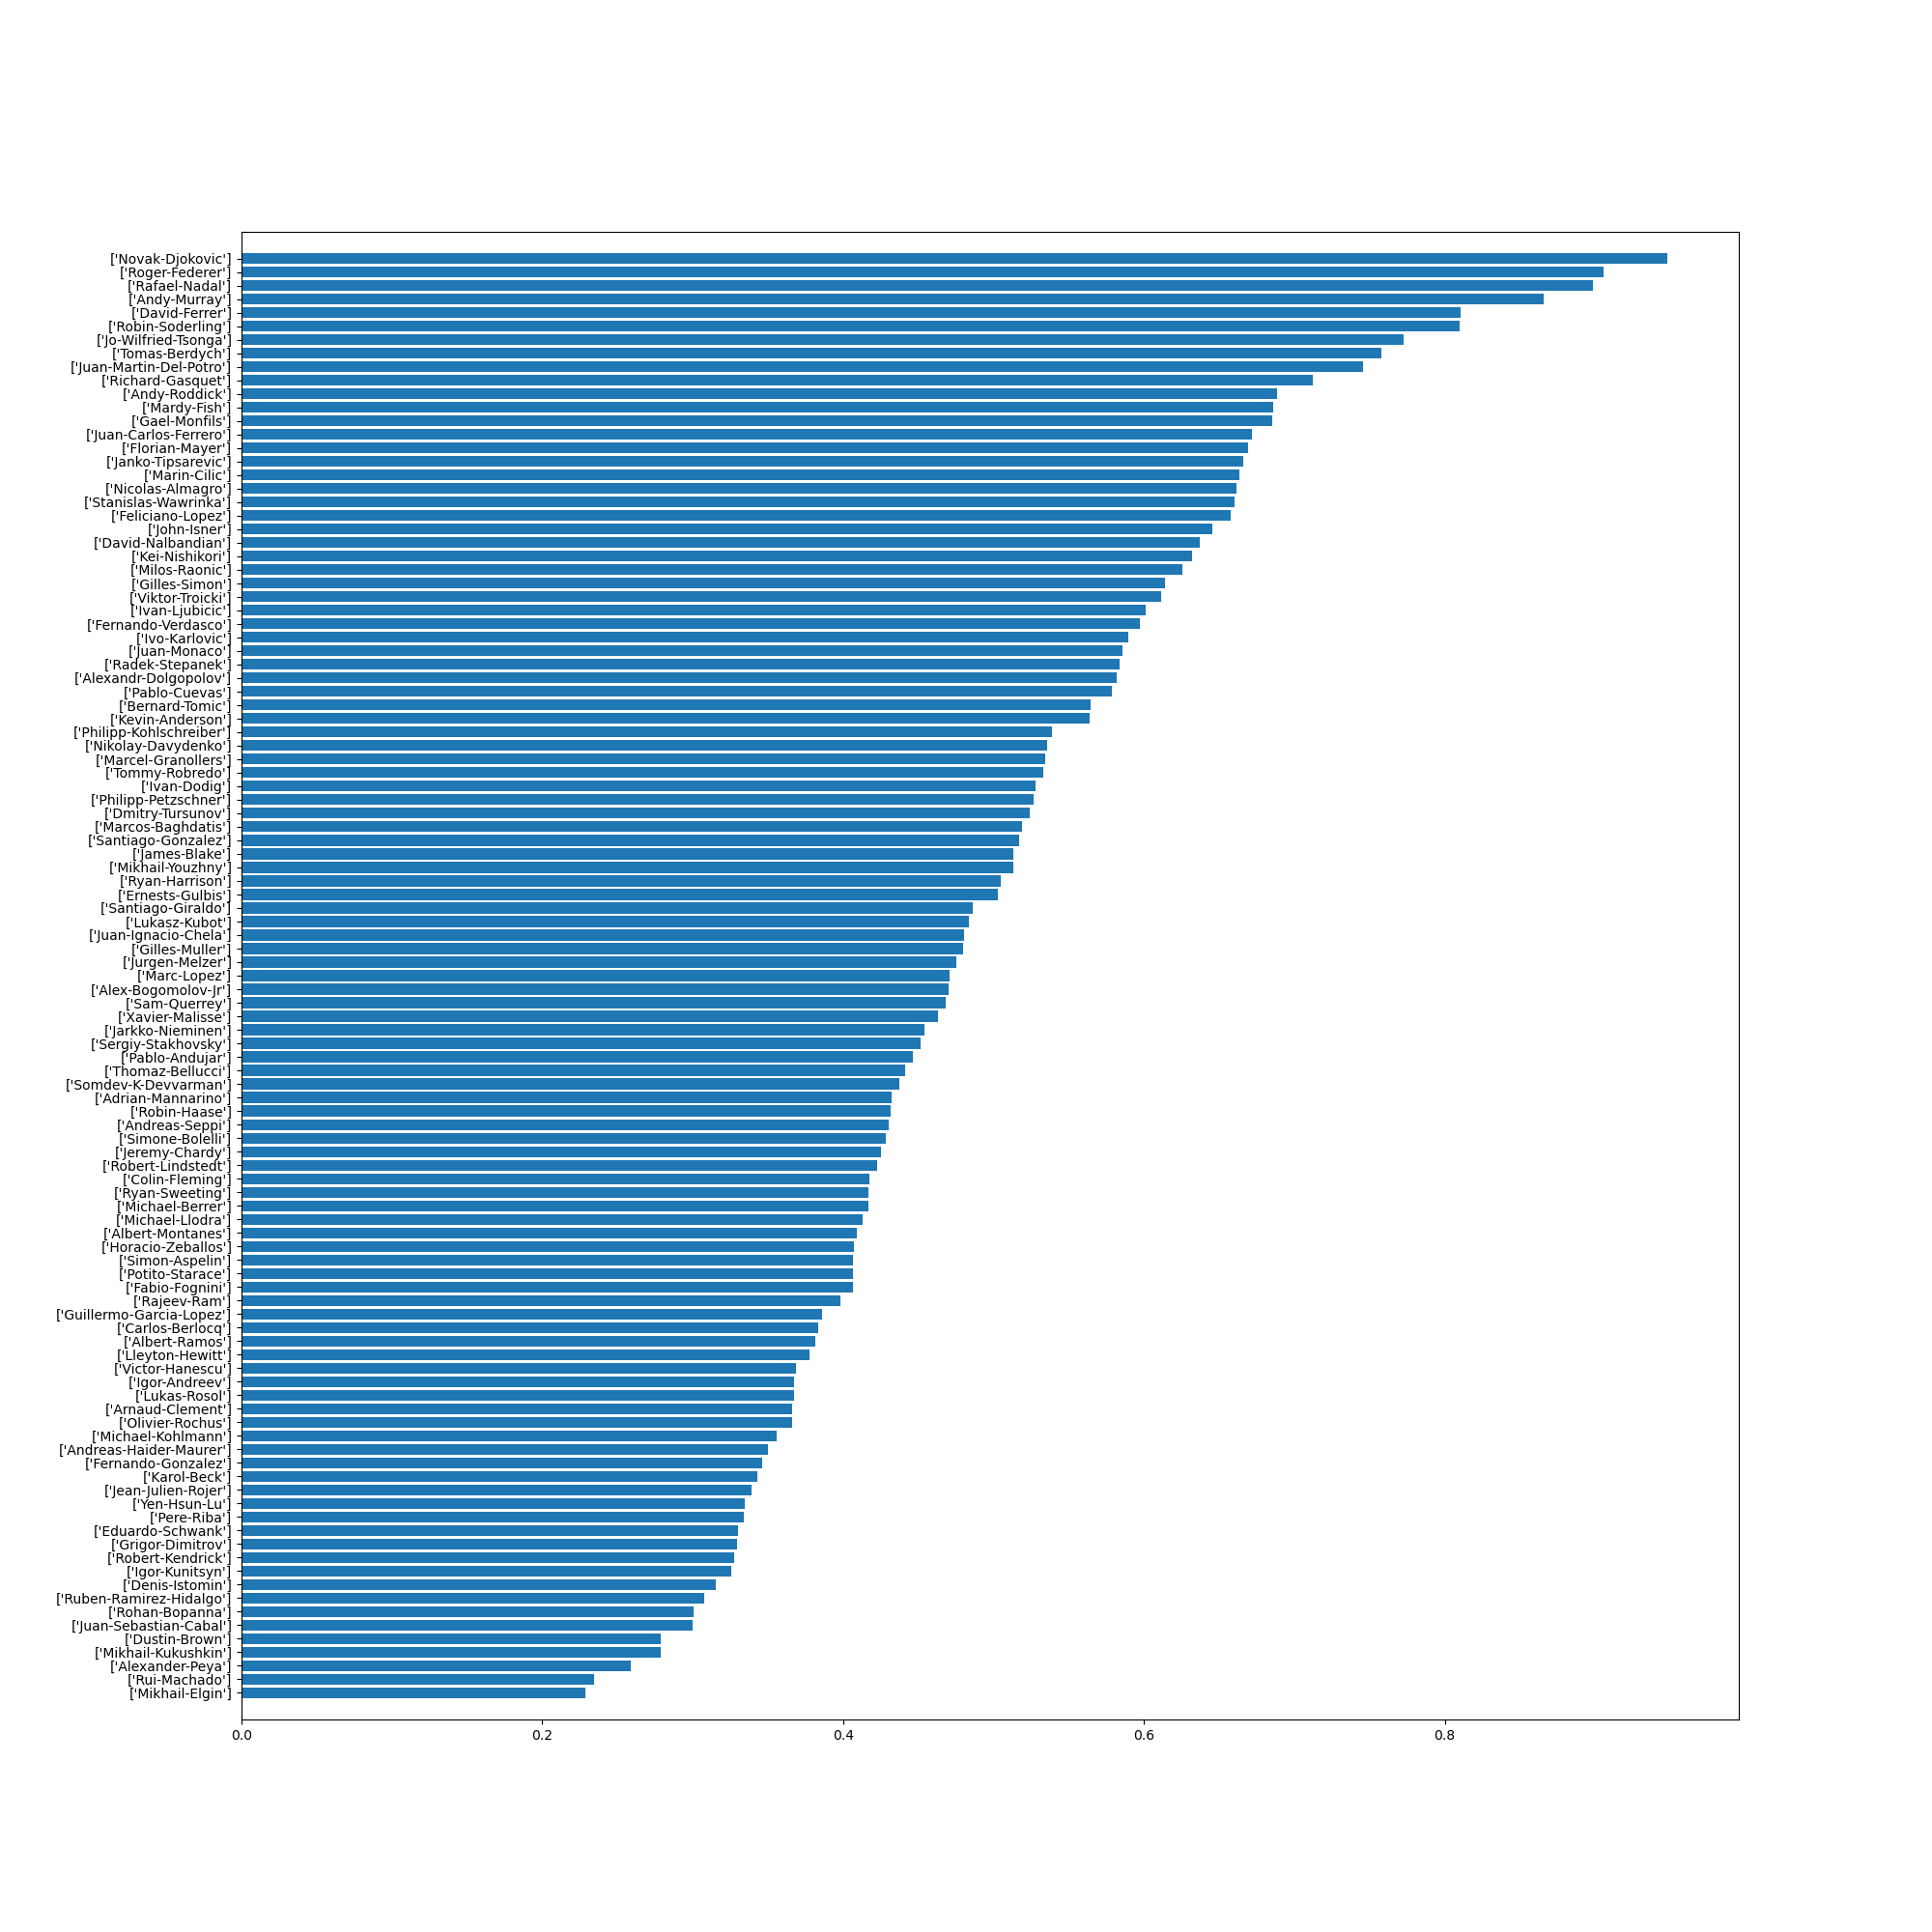

In [124]:
sorted_barplot(mpassing_probs, W)

In [126]:
gibbs_probs = np.zeros(107)
for player in range(107):
    gibbs_probs[player] = average_win_prob_gibbs(player, skillsg)

<IPython.core.display.Javascript object>


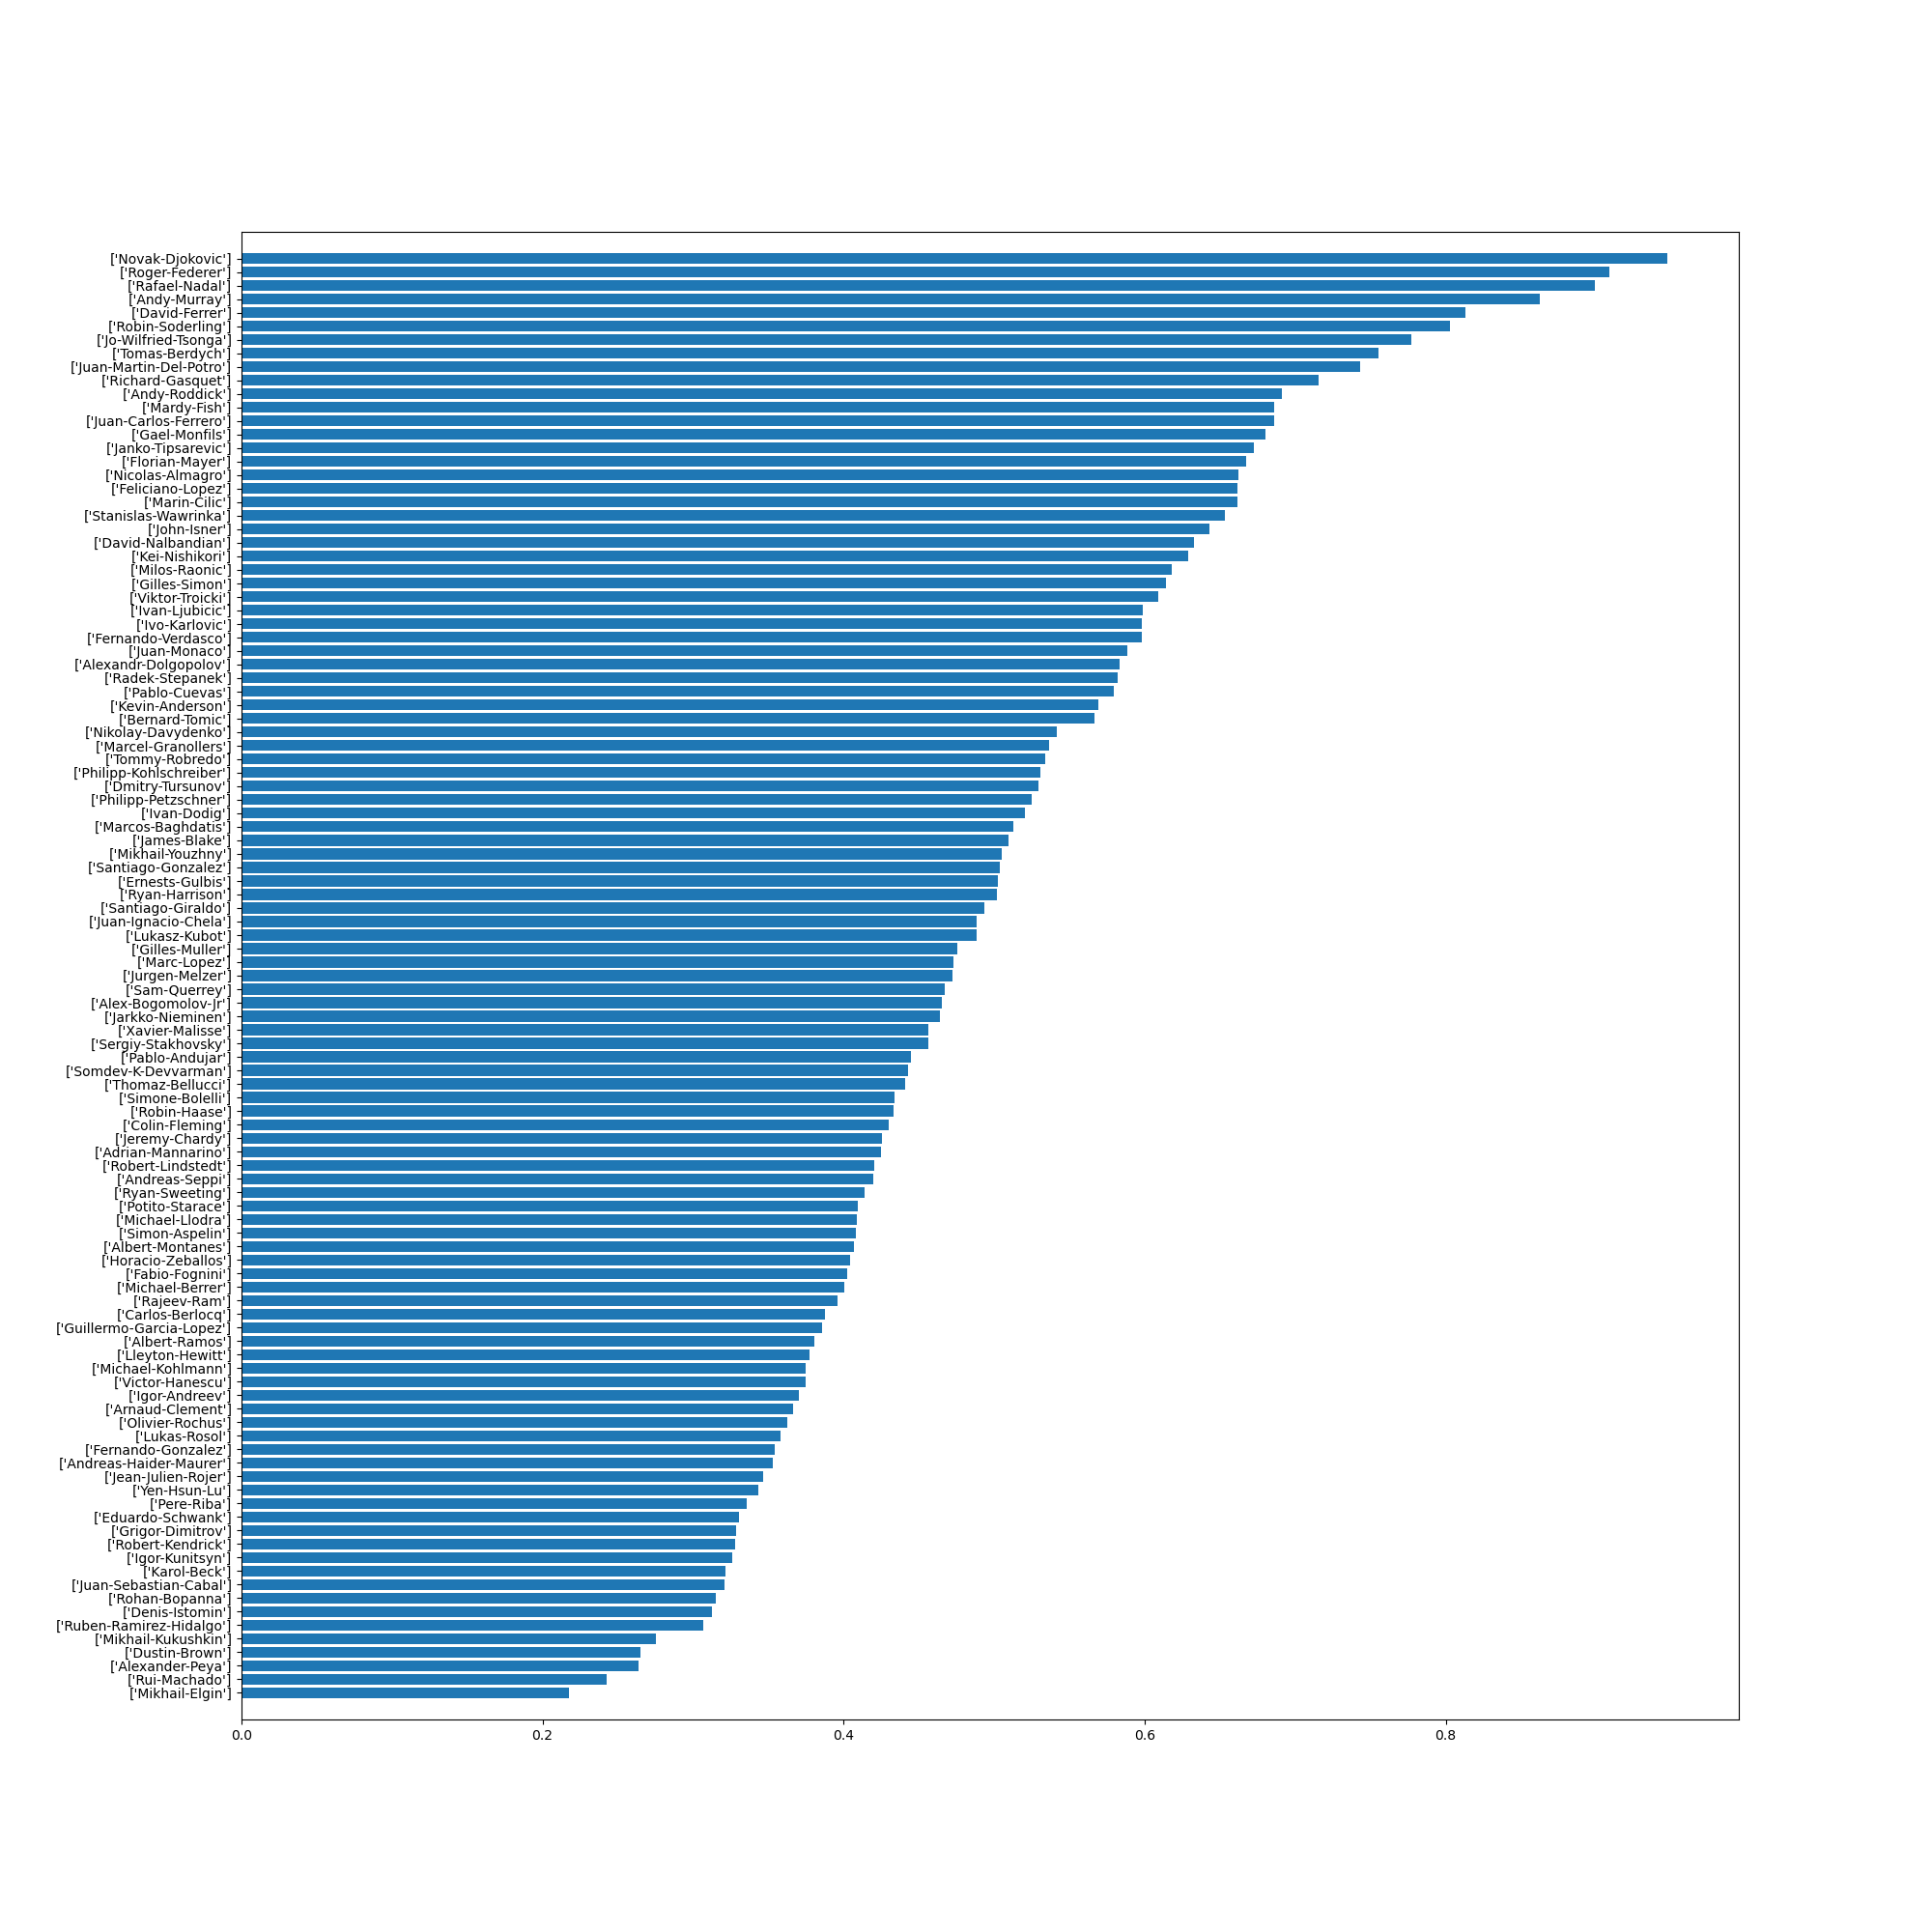

In [127]:
sorted_barplot(gibbs_probs, W)

In [128]:
direct_probs = np.zeros(107)
for player in range(107):
    direct_probs[player] = average_win_prob_direct(player, G)

<IPython.core.display.Javascript object>


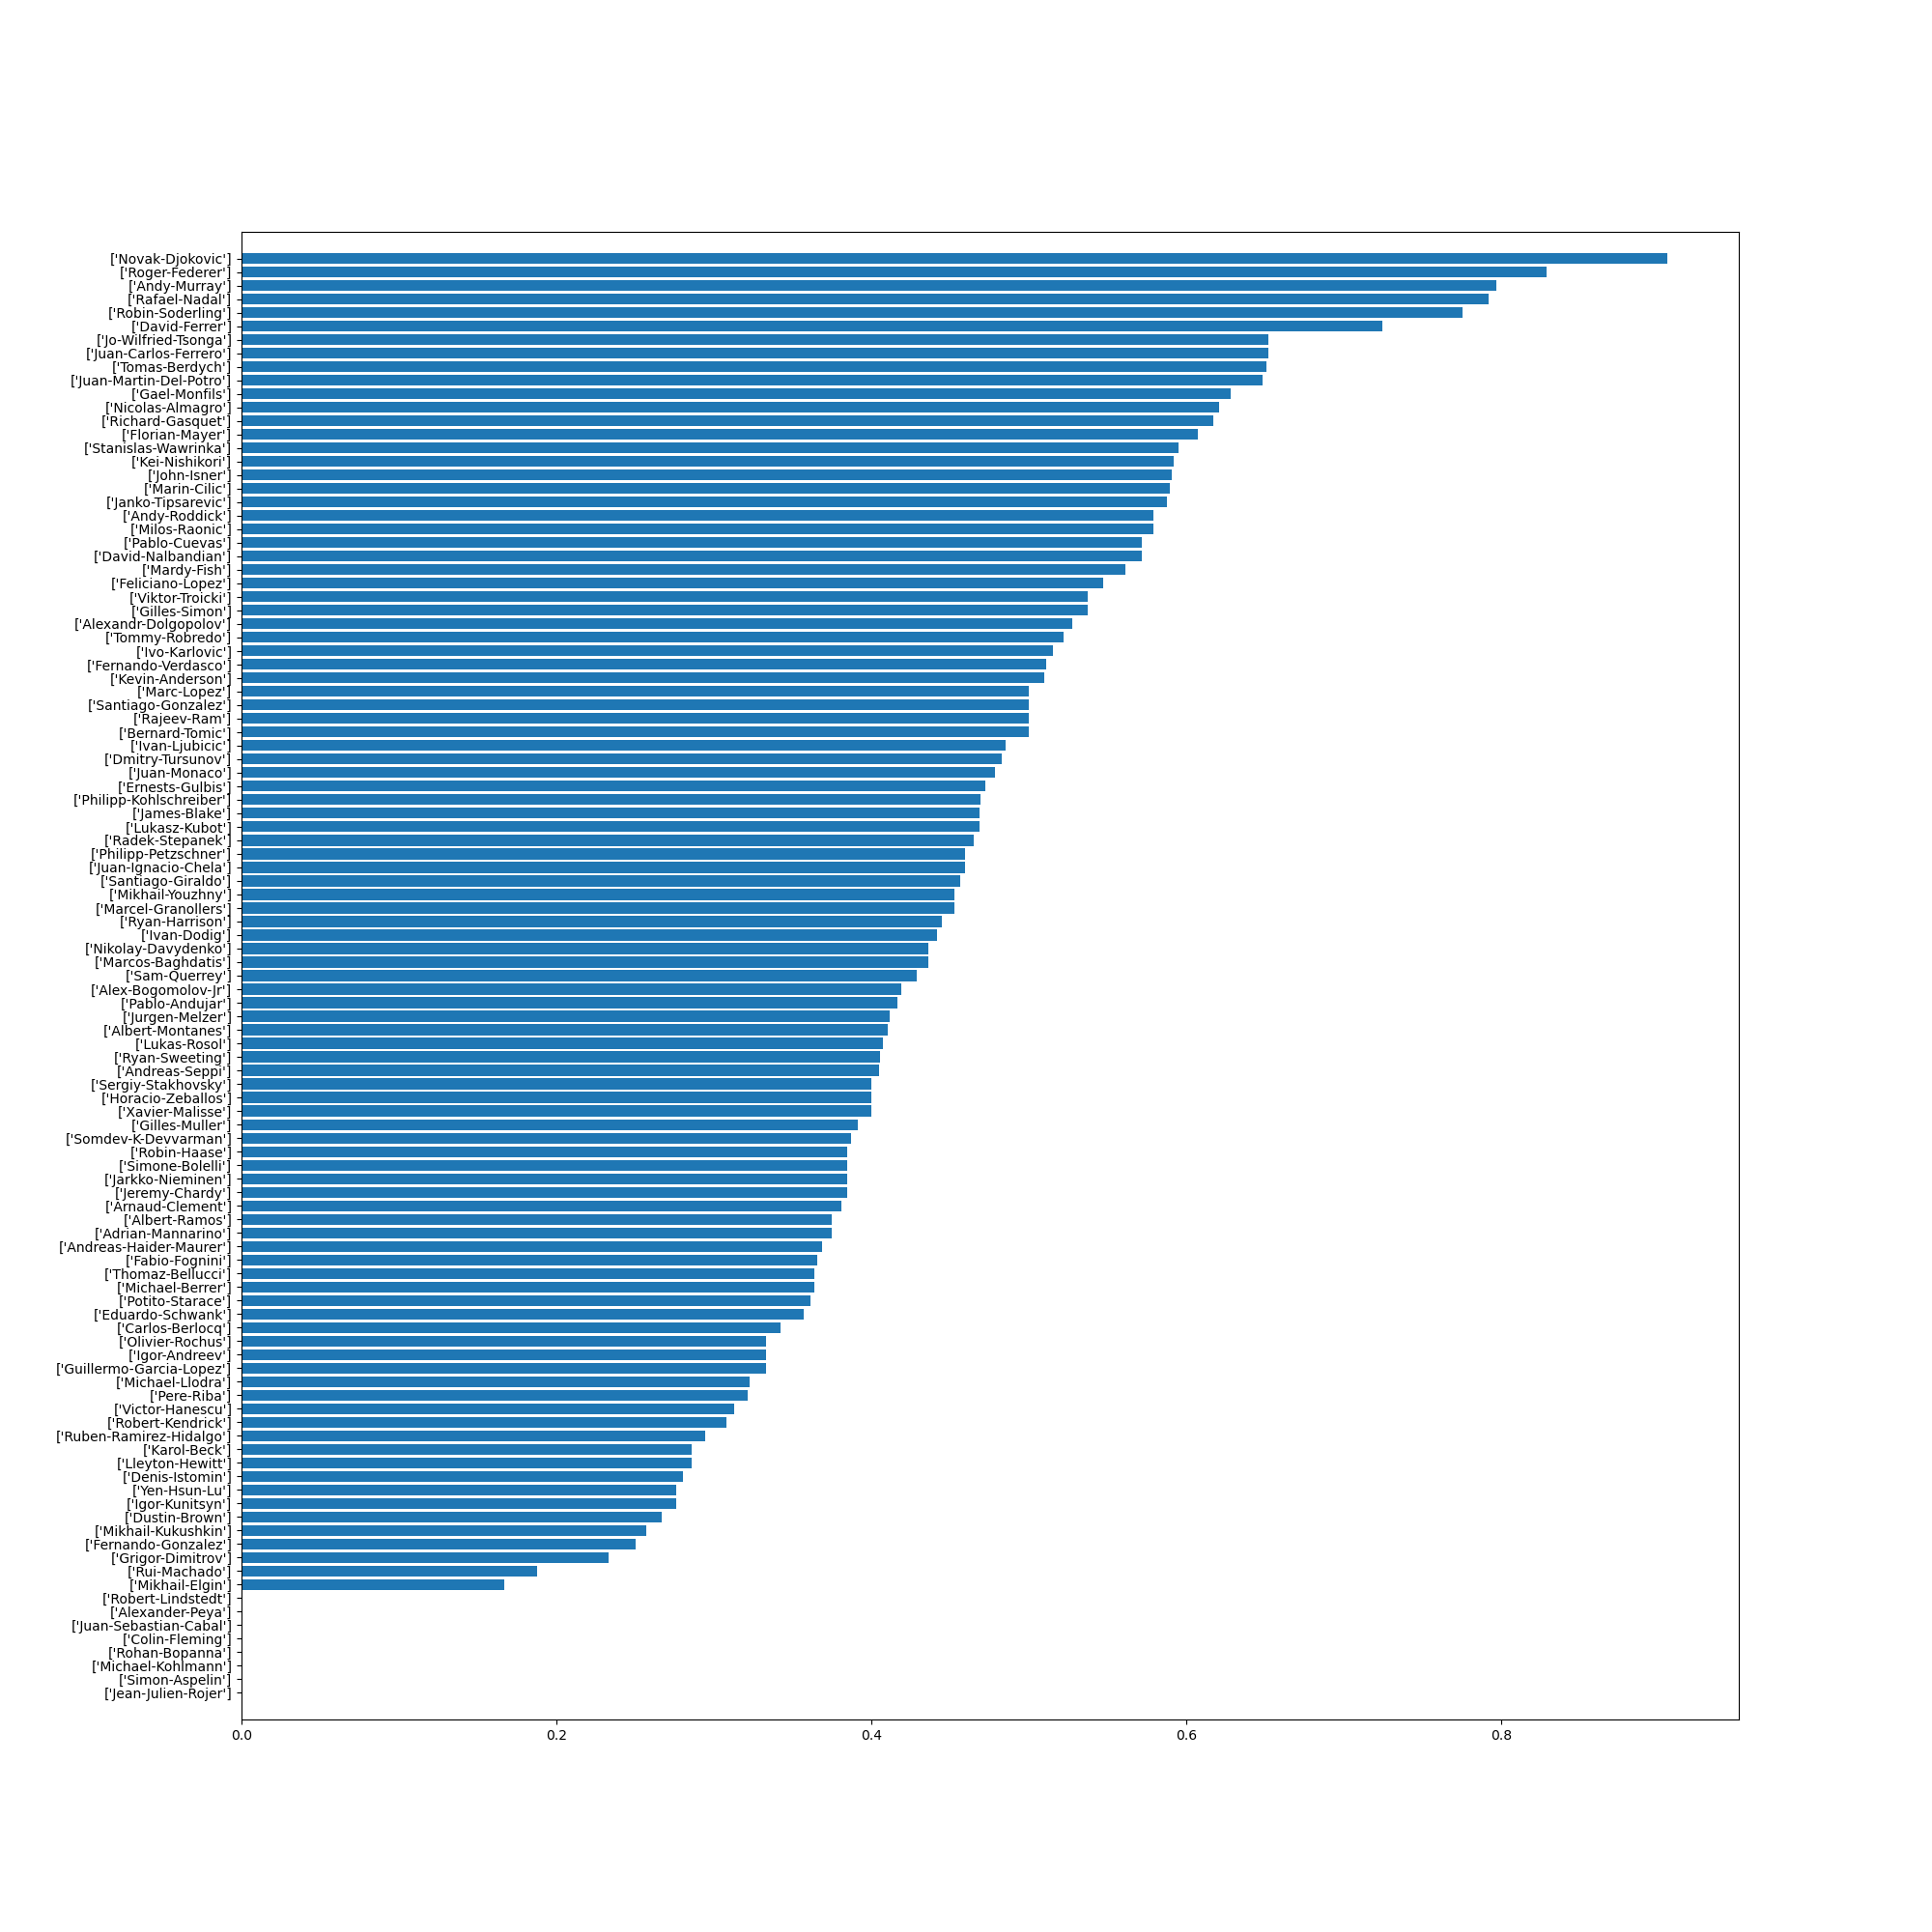

In [129]:
sorted_barplot(direct_probs, W)